In [1]:
import gc
import pandas as pd 
gc.collect()
df = pd.read_csv(r'C:\Users\nacer\Desktop\project\BCG X\transactions_dataset.csv', sep=';')
df['date_order'] = pd.to_datetime(df['date_order'])
df['date_invoice'] = pd.to_datetime(df['date_invoice'])
df["invoice_delay"] = (df["date_invoice"] - df["date_order"]).dt.days

# Remove clients who only made one transaction
transaction_counts = df['client_id'].value_counts()
clients_with_multiple_transactions = transaction_counts[transaction_counts > 1].index
df = df[df['client_id'].isin(clients_with_multiple_transactions)]

# Remove rows where invoice_delay is negative
df = df[df["invoice_delay"] >= 0]
df.shape


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Users\nacer\anaconda3\envs\foo-env\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\nacer\anaconda3\envs\foo-env\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c:\Users\nacer\anaconda3\envs\foo-env\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\nacer\anaconda3\envs\foo-env\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.s

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Users\nacer\anaconda3\envs\foo-env\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\nacer\anaconda3\envs\foo-env\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c:\Users\nacer\anaconda3\envs\foo-env\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\nacer\anaconda3\envs\foo-env\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.s

AttributeError: _ARRAY_API not found

(63312905, 9)

## Churn Definition : ##


c:\Users\nacer\anaconda3\envs\foo-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


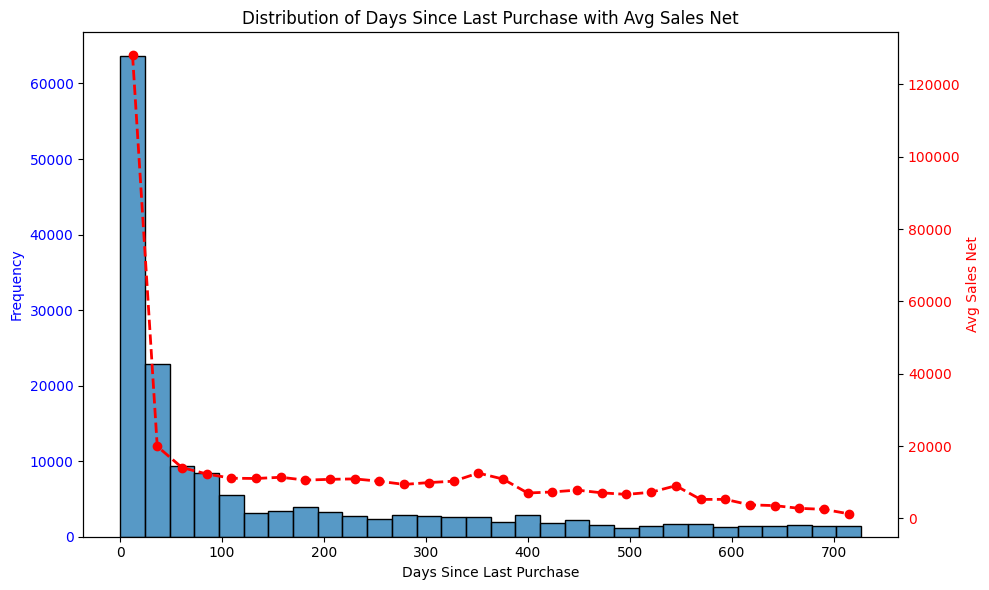

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Define last_purchase_dates as the difference between the max date of df and the last purchase of each client
last_purchase_dates = df.groupby('client_id')['date_order'].max().reset_index()
last_purchase_dates['days_since_last_purchase'] = (df['date_order'].max() - last_purchase_dates['date_order']).dt.days
avg_sales_per_client = df.groupby('client_id')['sales_net'].sum().reset_index()
avg_sales_per_client.columns = ['client_id', 'avg_sales_net']

# Merge with last_purchase_dates to get days_since_last_purchase
last_purchase_dates = last_purchase_dates.merge(avg_sales_per_client, on='client_id', how='left')

# Plot the distribution of days_since_last_purchase with average sales
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the histogram on the first y-axis
sns.histplot(last_purchase_dates, x='days_since_last_purchase', bins=30, kde=False, stat='count', ax=ax1)
ax1.set_xlabel('Days Since Last Purchase')
ax1.set_ylabel('Frequency', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Calculate the average sales for each bin
bin_edges = np.histogram_bin_edges(last_purchase_dates['days_since_last_purchase'], bins=30)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
avg_sales_per_bin = []

for i in range(len(bin_edges) - 1):
    bin_mask = (last_purchase_dates['days_since_last_purchase'] >= bin_edges[i]) & (last_purchase_dates['days_since_last_purchase'] < bin_edges[i + 1])
    avg_sales_per_bin.append(last_purchase_dates[bin_mask]['avg_sales_net'].mean())

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(bin_centers, avg_sales_per_bin, color='red', marker='o', linestyle='dashed', linewidth=2, markersize=6, label='Avg Sales Net')
ax2.set_ylabel('Avg Sales Net', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Distribution of Days Since Last Purchase with Avg Sales Net')
fig.tight_layout()  # Adjust layout to make room for the second y-axis
# Save the plot as a PNG file
fig.savefig('days_since_last_purchase_vs_avg_sales_net.png')
plt.show()

In [3]:
# 2. Determine the maximum date in the entire dataset
overall_max_date = df['date_order'].max()

# 3. Compute the last purchase date for each customer
last_purchase = df.groupby('client_id')[['client_id','date_order']].max()

# 4. Define a threshold: 1 year before overall_max_date
one_year_before = overall_max_date - pd.DateOffset(months=6)

# 5. Label customers as churned if their last purchase was before the threshold
last_purchase['Churn'] = last_purchase['date_order'] < one_year_before

# Convert boolean series to int and keep client_id
last_purchase['Churn'] = last_purchase['Churn'].astype(int)

last_purchase.reset_index(drop=True, inplace=True)

df = df.merge(last_purchase[['client_id', 'Churn']], on='client_id', how='inner')
df.head()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id,invoice_delay,Churn
0,2017-09-25,2017-09-25,2376333,188502,155.44320,3,online,2732,0.0,0
1,2017-09-25,2017-09-25,2520527,835089,16.39440,3,at the store,10279,0.0,0
2,2017-09-25,2017-09-25,2536756,1977896,365.76624,21,online,6184,0.0,1
3,2017-09-25,2017-09-25,3028673,598816,8.59878,201,at the store,4200,0.0,0
4,2017-09-25,2017-09-25,203377,2086861,1093.37400,3,by phone,7051,0.0,0


## Data Preprocessing : ##

In [4]:
df_train = df[df['date_order'] < pd.Timestamp('2019-01-01 00:00:00')]
df_test = df[df['date_order'] >= pd.Timestamp('2019-01-01 00:00:00')]

In [5]:
import pandas as pd
import numpy as np

def process_dataframe(df):
    """
    Enhances your existing feature engineering steps with:
      1) Cohort-based features (monthly_cohort)
      2) Days since first purchase
      3) Slopes (spending and frequency) over monthly aggregations
    """
    # Calculate each customer's first and last purchase date
    customer_activity = (
        df_test.groupby("client_id")
        .agg(
            first_purchase=("date_order", "min"),
            last_purchase=("date_order", "max"),
            total_frequency=("client_id", "count"),  # Total transactions
            total_monetary=("sales_net", "sum"),  # Total net sales
        )
        .reset_index()
    )

    customer_activity["active_days"] = (
    customer_activity["last_purchase"] - customer_activity["first_purchase"]
    ).dt.days
    customer_activity["active_days"] = customer_activity["active_days"].replace(
        0, 1
    ) 

    # **Fix: Apply a minimum observation window (e.g., 30 days)**
    customer_activity["adjusted_active_days"] = np.maximum(
        customer_activity["active_days"], 30
    )

    df = df[df['client_id'].isin(customer_activity['client_id'].tolist())]

    # 1. Identify the overall max date
    max_date = df['date_order'].max()

    # 2. Last Purchase (existing logic)
    last_purchase = df.groupby('client_id')['date_order'].max().reset_index()
    last_purchase['days_since_last_purchase'] = (max_date - last_purchase['date_order']).dt.days
    df_days_since_last_purchase = last_purchase[['client_id', 'days_since_last_purchase']]

    # 3. FIRST Purchase (new logic)
    first_purchase = df.groupby('client_id')['date_order'].min().reset_index(name='first_purchase_date')

    # 4. Days Since First Purchase
    first_purchase['days_since_first_purchase'] = (max_date - first_purchase['first_purchase_date']).dt.days

    # Calculate the activity period (days between first and last purchase)
    first_purchase['activity_period'] = (last_purchase['date_order'] - first_purchase['first_purchase_date']).dt.days

    # 5. Monthly Cohort (year-month of first purchase)
    #    You could also do quarterly with: .dt.to_period('Q')
    first_purchase['monthly_cohort'] = first_purchase['first_purchase_date'].dt.to_period('Q').astype(str)

    # Merge first_purchase info
    df_days_since_last_purchase = df_days_since_last_purchase.merge(
        first_purchase[['client_id','first_purchase_date','days_since_first_purchase','monthly_cohort','activity_period']],
        on='client_id', how='left'
    )

    # 6. Create 6-month window subset (existing logic)
    start_date = max_date - pd.DateOffset(months=6)
    df_6_months = df[df['date_order'] >= start_date]

    # 7. Number of purchases in the 6-month window
    nb_purchase = df_6_months.groupby('client_id').size().reset_index(name='Nb_purchase_6months')

    # Filter out clients with only one purchase
    
    # 8. Sum of sales_net in the 6-month window
    total_sales_net = df_6_months.groupby('client_id')['sales_net'].sum().reset_index(name='Total_sales_net_6months')

    # 9. One-hot encoding of channels in 6-month window
    df_6_months_channel = pd.get_dummies(df_6_months[['client_id','order_channel']],
                                         columns=['order_channel'],
                                         prefix='channel')
    channel_usage = df_6_months_channel.groupby('client_id').sum().reset_index()

    # 10. Distinct products in 6-month window + total distinct products
    distinct_products_6_months = df_6_months.groupby('client_id')['product_id'].nunique() \
        .reset_index(name='Distinct_products_6_months')
    distinct_products_total = df.groupby('client_id')['product_id'].nunique() \
        .reset_index(name='Distinct_products_total')

    # Merge them all into df_days_since_last_purchase
    df_features = df_days_since_last_purchase.merge(distinct_products_6_months, on='client_id', how='left') \
                                             .merge(distinct_products_total, on='client_id', how='left') \
                                             .merge(nb_purchase, on='client_id', how='left') \
                                             .merge(total_sales_net, on='client_id', how='left') \
                                             .merge(channel_usage, on='client_id', how='left')

    # Replace NaNs with 0 where appropriate
    df_features.fillna(0, inplace=True)

    # 11. Compute Spending Slope & Frequency Slope for each client
    #     We'll group each client's data by month and do a simple linear regression (y = slope * x + intercept)
    #     on monthly sums (spending) and monthly counts (frequency).
    df_features_slopes = compute_slopes_simple(df)
    # This returns a DataFrame with columns: ['client_id','sales_slope','frequency_slope']

    # 12. Merge slope features
    df_features = df_features.merge(df_features_slopes, on='client_id', how='left')

    
    # RFM Calculation
    '''rfm = (df.groupby("client_id").agg(recency=("date_order", lambda x: (max_date - x.max()).days),frequency=("client_id", "count"),monetary=("sales_net", "sum"),).reset_index())
    rfm["recency_score"] = pd.qcut(rfm["recency"], q=4, labels=[4, 3, 2, 1]).astype(int)
    rfm["frequency_score"] = pd.qcut(rfm["frequency"], q=4, labels=[1, 2, 3, 4]).astype(int)
    rfm["monetary_score"] = pd.qcut(rfm["monetary"], q=4, labels=[1, 2, 3, 4]).astype(int)

    # Compute final RFM score
    rfm["rfm_score"] = rfm["recency_score"] + rfm["frequency_score"] + rfm["monetary_score"]

    def rfm_segment(row):
        if row["rfm_score"] >= 10:
            return 0
        elif row["rfm_score"] >= 7:
            return 0.5
        elif row["rfm_score"] >= 4:
            return 0.8
        else:
            return 1
        

    rfm["Churn_RFM"] = rfm.apply(rfm_segment, axis=1)

    df_features = df_features.merge(rfm, on='client_id', how='left')'''

    grouped_df_test = df.groupby('client_id')['Churn'].max().reset_index()
# Merge df_days_since_last_purchase with df_train to get back the churn feature
   
    df_features = df_features.merge(grouped_df_test[['client_id', 'Churn']], on='client_id', how='inner')

    df_features.drop(columns=['first_purchase_date'],inplace=True)

    
    # Split 'monthly_cohort' into 'year' and 'quarter'
    df_features[['first_purchase_year', 'first_purchase_quarter']] = df_features['monthly_cohort'].str.extract(r'(\d{4})(Q\d)')

    # Convert 'first_purchase_year' to integer
    df_features['first_purchase_year'] = df_features['first_purchase_year'].astype(int)

    df_features.drop(columns=['monthly_cohort'], inplace=True)

    # Drop the original 'first_purchase_quarter' column
    df_features.drop(columns=['first_purchase_quarter'], inplace=True)
    
    return df_features

def compute_slopes(df):
    """
    For each client:
      1) Group by year-month, sum sales_net -> monthly spending
      2) Group by year-month, count rows -> monthly frequency
      3) Do a simple linear regression of spending/frequency over time to get a slope
    Returns a DataFrame with [client_id, sales_slope, frequency_slope].
    """

    # Make sure date_order is datetime

    # Container for results
    results = []

    # Group by client
    for client_id, grp in df.groupby('client_id'):
        # Sort by date
        grp = grp.sort_values('date_order')

        # Create a year_month period column
        grp['year_month'] = grp['date_order'].dt.to_period('M')

        # 1) Spending slope
        monthly_spend = grp.groupby('year_month')['sales_net'].sum().reset_index()
        monthly_spend = monthly_spend.sort_values('year_month')
        monthly_spend['time_idx'] = range(len(monthly_spend))

        if len(monthly_spend) > 1:
            slope_spend, intercept_spend = np.polyfit(monthly_spend['time_idx'], monthly_spend['sales_net'], 1)
        else:
            # If there's only 1 data point, slope is 0
            slope_spend = 0

        # 2) Frequency slope
        monthly_freq = grp.groupby('year_month').size().reset_index(name='purchases')
        monthly_freq = monthly_freq.sort_values('year_month')
        monthly_freq['time_idx'] = range(len(monthly_freq))

        if len(monthly_freq) > 1:
            slope_freq, intercept_freq = np.polyfit(monthly_freq['time_idx'], monthly_freq['purchases'], 1)
        else:
            slope_freq = 0

        results.append({
            'client_id': client_id,
            'sales_slope': slope_spend,
            'frequency_slope': slope_freq
        })
        

    return pd.DataFrame(results)



def compute_slopes_simple(df):
    """
    For each client:
      1) Convert each transaction's date_order to a monthly period (year-month).
      2) Aggregate by (client_id, year_month) to get:
         - total monthly spending (sales_net sum)
         - monthly transaction count (frequency)
      3) Sort each client's monthly data by time, assign a time index (0, 1, 2, ...)
      4) Compute slope as a simple difference between the first and last data points:
           slope = (value_last - value_first) / (time_idx_last - time_idx_first)
         If only one monthly data point is available, slope is 0.
    Returns a DataFrame: [client_id, sales_slope, frequency_slope].
    """
    

    # Ensure date_order is datetime
    df['date_order'] = pd.to_datetime(df['date_order'], errors='coerce')

    # 1) Create a monthly period from date_order
    df['year_month'] = df['date_order'].dt.to_period('M')

    # 2) Aggregate by client_id and year_month:
    #    - total monthly spend
    #    - count of transactions (frequency)
    monthly = df.groupby(['client_id','year_month']).agg(
        sales_net=('sales_net', 'sum'),
        purchases=('date_order', 'count')  # or size() if you prefer
    ).reset_index()

    # 3) Sort by client then by year_month
    monthly = monthly.sort_values(['client_id','year_month'])

    # Assign a time_idx for each row within the client, counting from 0, 1, 2, ...
    monthly['time_idx'] = monthly.groupby('client_id').cumcount()

    # 4) Compute slope from first to last monthly data point
    def slope_func(group):
        if len(group) == 1:
            # Only one month of data => slope is 0
            return pd.Series({'sales_slope': 0.0, 'frequency_slope': 0.0})

        first_row = group.iloc[0]
        last_row = group.iloc[-1]

        # time_idx goes from 0 to (N-1)
        delta_t = last_row['time_idx'] - first_row['time_idx']
        if delta_t == 0:
            return pd.Series({'sales_slope': 0.0, 'frequency_slope': 0.0})

        # sales_slope = (last_month_spend - first_month_spend) / number_of_months_between
        sales_slope = (last_row['sales_net'] - first_row['sales_net']) / delta_t

        # frequency_slope = (last_month_purchases - first_month_purchases) / number_of_months_between
        freq_slope = (last_row['purchases'] - first_row['purchases']) / delta_t

        return pd.Series({'sales_slope': sales_slope, 'frequency_slope': freq_slope})

    # Apply the slope_func to each client's group
    result = monthly.groupby('client_id').apply(slope_func).reset_index()

    return result



## Training

In [6]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt


df_train_processed = process_dataframe(df_train)


# Define the features and target variable
X = df_train_processed.drop(columns=['client_id', 'Churn'])
y = df_train_processed['Churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]))

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_model.predict(X_test)

y_proba = xgb_model.predict_proba(X_test)[:, 1]






C:\Users\nacer\AppData\Local\Temp\ipykernel_16404\1969044933.py:223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_order'] = pd.to_datetime(df['date_order'], errors='coerce')
C:\Users\nacer\AppData\Local\Temp\ipykernel_16404\1969044933.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year_month'] = df['date_order'].dt.to_period('M')
C:\Users\nacer\AppData\Local\Temp\ipykernel_16404\1969044933.py:265: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior

### Evaluation

Test Accuracy: 0.77
Confusion Matrix:
[[16474  4360]
 [  810   821]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.79      0.86     20834
           1       0.16      0.50      0.24      1631

    accuracy                           0.77     22465
   macro avg       0.56      0.65      0.55     22465
weighted avg       0.90      0.77      0.82     22465

Accuracy: 0.77


<Figure size 1000x800 with 0 Axes>

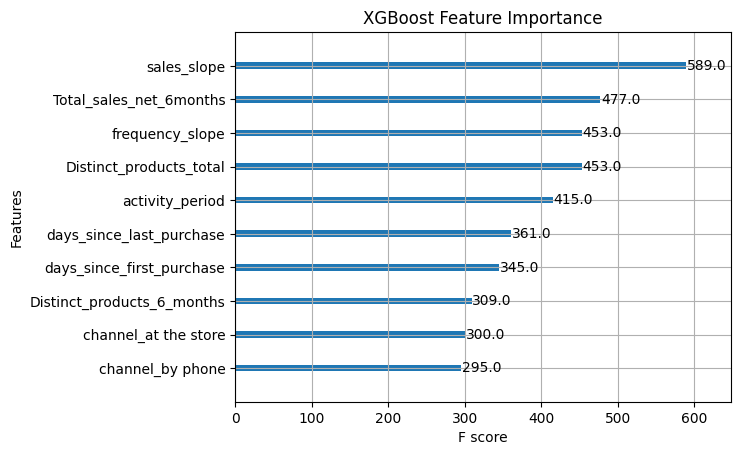

In [7]:
# Define a custom threshold
threshold = 0.6

# Convert probabilities to binary predictions using the custom threshold
# (>= 0.7 => label=1, otherwise label=0)
y_pred_custom = (y_proba >= threshold).astype(int)


# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_custom)
conf_matrix = confusion_matrix(y_test, y_pred_custom)
class_report = classification_report(y_test, y_pred_custom)

print(f"Test Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

print(f"Accuracy: {accuracy:.2f}")
# Plot the confusion matrix




from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, max_num_features=10, importance_type='weight')
plt.title('XGBoost Feature Importance')
plt.show()

## Prediction

C:\Users\nacer\AppData\Local\Temp\ipykernel_16404\1969044933.py:265: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = monthly.groupby('client_id').apply(slope_func).reset_index()


Test Accuracy: 0.77
Confusion Matrix:
[[89253 29491]
 [  520  9315]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.75      0.86    118744
           1       0.24      0.95      0.38      9835

    accuracy                           0.77    128579
   macro avg       0.62      0.85      0.62    128579
weighted avg       0.94      0.77      0.82    128579



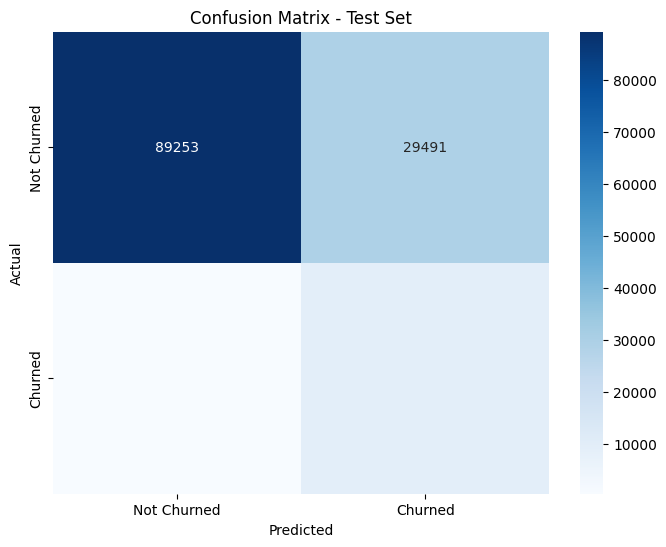

In [8]:
df_test_processed = process_dataframe(df_test)



# Define the features and target variable for the test set
X_test_final = df_test_processed.drop(columns=['client_id', 'Churn'])
y_test_final = df_test_processed['Churn']




# Make predictions on the test data
y_pred_test = xgb_model.predict(X_test_final)
# Get the client_id of the people that were predicted 1 for churn

y_proba = xgb_model.predict_proba(X_test_final)[:, 1]

threshold = 0.65

# Convert probabilities to binary predictions using the custom threshold
# (>= 0.7 => label=1, otherwise label=0)
y_pred_test = (y_proba >= threshold).astype(int)

# Evaluate the model
accuracy_test = accuracy_score(y_test_final, y_pred_test)
conf_matrix_test = confusion_matrix(y_test_final, y_pred_test)
class_report_test = classification_report(y_test_final, y_pred_test)

print(f"Test Accuracy: {accuracy_test:.2f}")
print("Confusion Matrix:")
print(conf_matrix_test)
print("Classification Report:")
print(class_report_test)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churned', 'Churned'], yticklabels=['Not Churned', 'Churned'])
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [9]:
# balanced accuracy
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy = balanced_accuracy_score(y_test_final, y_pred_test)

print(f"Balanced Accuracy: {balanced_accuracy:.2f}")

Balanced Accuracy: 0.85


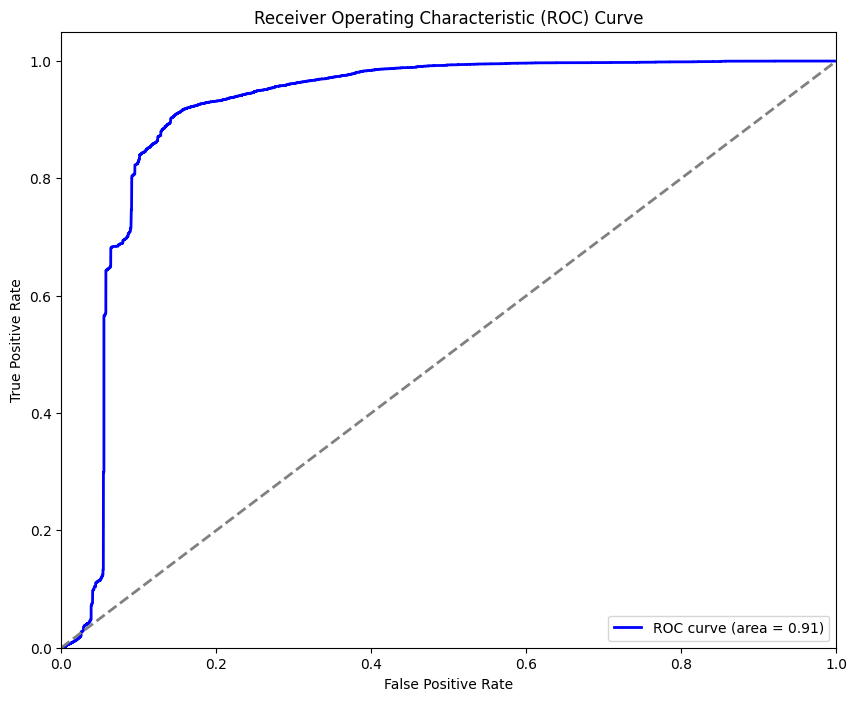

In [10]:
from sklearn.metrics import roc_curve, auc

# Compute the ROC curve and AUC for the test set
fpr, tpr, _ = roc_curve(y_test_final, y_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Save the plot as a PNG file
plt.savefig('roc_curve.png')

plt.show()

In [11]:
churned_clients = df_test_processed.loc[y_pred_test == 1, 'client_id']
print(churned_clients)
# Save churned_clients as an Excel file

# Create a dataframe with client_id and their churn prediction
churn_predictions = pd.DataFrame({'client_id': df_test_processed['client_id'], 'predicted_churn': y_pred_test})
churn_predictions
churn_predictions.to_csv('churned_prediction.csv', index=False)


6              60
7              67
8              68
9              76
13            120
           ...   
128557    2274173
128564    2274269
128573    2274425
128576    2274479
128577    2274504
Name: client_id, Length: 38806, dtype: int64
